In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm

In [2]:
dataset_dir="/home/sumitm/grasp-and-lift-eeg-detection/train/subj10_series1_"

inputs = {
    "data": f"{dataset_dir}data.csv",
    "events": f"{dataset_dir}events.csv",
}

data_specifications = {}
for k, v in inputs.items():
    print(k)
    data_specifications[k] = pd.read_csv(v)

data
events


In [3]:
data_specifications['events'].describe()


,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
count,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000
mean,0.019437,0.019437,0.019437,0.019437,0.019437,0.019437
std,0.138055,0.138055,0.138055,0.138055,0.138055,0.138055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
data_specifications['data'].describe()


,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,...,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000,262387.000000
mean,-86.238510,-208.771627,-122.016967,-427.069051,-351.648542,-206.431222,-323.689005,-54.680392,-236.035692,-304.621666,...,-204.783690,-369.480565,-125.396853,-243.953611,-119.396578,-330.901874,-218.154139,-640.792612,-353.016826,-467.407311
std,269.620152,254.806070,278.971481,161.268718,146.001852,270.501995,168.565288,190.552756,71.387063,194.954165,...,176.353497,186.829252,164.629680,140.499600,178.106856,171.757050,170.681583,185.227185,159.828020,209.278635
min,-1086.000000,-1224.000000,-1495.000000,-989.000000,-758.000000,-1448.000000,-3503.000000,-1197.000000,-498.000000,-914.000000,...,-1097.000000,-1442.000000,-972.000000,-1028.000000,-1195.000000,-1661.000000,-1342.000000,-1801.000000,-1614.000000,-1774.000000
25%,-250.000000,-358.000000,-281.000000,-537.000000,-458.000000,-377.000000,-435.000000,-168.000000,-289.000000,-433.000000,...,-321.000000,-487.000000,-241.000000,-339.000000,-234.000000,-442.000000,-333.000000,-765.000000,-457.000000,-610.000000
50%,-84.000000,-203.000000,-115.000000,-435.000000,-355.000000,-233.000000,-322.000000,-42.000000,-229.000000,-308.000000,...,-203.000000,-367.000000,-130.000000,-244.000000,-117.000000,-330.000000,-221.000000,-647.000000,-355.000000,-468.000000
75%,67.000000,-59.000000,37.000000,-322.000000,-257.000000,-49.000000,-210.000000,76.000000,-183.000000,-186.000000,...,-87.000000,-249.000000,-13.000000,-151.000000,-2.000000,-217.000000,-108.000000,-522.000000,-250.000000,-325.000000
max,2414.000000,2307.000000,1921.000000,498.000000,161.000000,824.000000,1888.000000,995.000000,-4.000000,284.000000,...,864.000000,360.000000,562.000000,316.000000,860.000000,454.000000,534.000000,143.000000,411.000000,409.000000


def timeplots(df,t = False):
    
    for x in df:
        if x != 'timestamps':
            plt.figure(figsize=(20,5))
            if (t==False):
                plt.boxplot(df[x])
                plt.title(x)
                plt.xlabel('time')
                plt.show()
            plt.figure(figsize=(20,5))
            plt.plot(df['timestamps'],df[x])
            plt.title(x)
            plt.xlabel('time')
            plt.show()
timeplots(data_specifications['data'])

In [5]:
df = (data_specifications['data'])

In [6]:
print(list(df))
len(list(df))


['id', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']


33

['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO']

In [8]:
SEEDlist = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO']

In [11]:
len(SEEDlist)

66

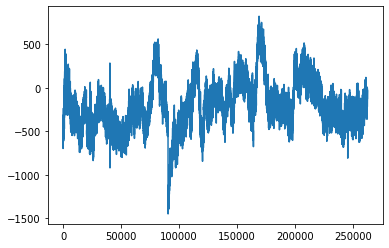

In [9]:
plt.plot(df['F4'])

In [7]:
test = list()
for x in list(df):
    test.append(x.upper())
test

['ID',
 'FP1',
 'FP2',
 'F7',
 'F3',
 'FZ',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'CZ',
 'C4',
 'T8',
 'TP9',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'TP10',
 'P7',
 'P3',
 'PZ',
 'P4',
 'P8',
 'PO9',
 'O1',
 'OZ',
 'O2',
 'PO10']

In [13]:
motionset = set(test)
emotionset = set(SEEDlist)
print(emotionset.intersection(motionset))

{'CP5', 'P7', 'CP1', 'FP2', 'F4', 'P3', 'O1', 'FC5', 'FC1', 'T8', 'PZ', 'O2', 'FC6', 'T7', 'F7', 'F3', 'C4', 'FC2', 'CP6', 'F8', 'OZ', 'FZ', 'FP1', 'C3', 'CZ', 'CP2', 'P8', 'P4'}


In [15]:
intersection = ['Fp1', 'FC1', 'Fp2', 'P7', 'FC5', 'T7', 'F8', 'P4', 'CP5', 'P3', 'T8', 'Oz', 'FC6', 'O2', 'Cz', 'Fz', 'P8', 'C3', 'CP6', 'CP2', 'CP1', 'Pz', 'O1', 'F3', 'F7', 'C4', 'FC2', 'F4']
print(list(intersection))
len(list(intersection))

['Fp1', 'FC1', 'Fp2', 'P7', 'FC5', 'T7', 'F8', 'P4', 'CP5', 'P3', 'T8', 'Oz', 'FC6', 'O2', 'Cz', 'Fz', 'P8', 'C3', 'CP6', 'CP2', 'CP1', 'Pz', 'O1', 'F3', 'F7', 'C4', 'FC2', 'F4']


28

In [16]:
df['F4'].tail(1)

262386   -120
Name: F4, dtype: int64

In [17]:
df[intersection].shape

(262387, 28)

In [23]:
df[intersection].values.shape

(262387, 28)